In [ ]:
import tensorflow as tf
import numpy as np
import time
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from PIL import Image
from tensorflow.keras import layers, models, optimizers



In [ ]:
def build_model(input_shape=(10, 40, 40, 1)):

    model = models.Sequential([
        layers.ConvLSTM2D(filters=64, kernel_size=(3, 3), padding='same',
                          return_sequences=True, activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),

        layers.ConvLSTM2D(filters=64, kernel_size=(3, 3), padding='same',
                          return_sequences=True, activation='relu'),
        layers.BatchNormalization(),

        layers.ConvLSTM2D(filters=32, kernel_size=(3, 3), padding='same',
                          return_sequences=True, activation='relu'),
        layers.BatchNormalization(),

        layers.Conv3D(filters=1, kernel_size=(3, 3, 3), padding='same', activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [ ]:
def generate_movies(n_samples=1200, n_frames=20):
    row = 80
    col = 80
    noisy_movies = np.zeros((n_samples, n_frames, row, col, 1), dtype=float)
    shifted_movies = np.zeros((n_samples, n_frames, row, col, 1),
                              dtype=float)

    for i in range(n_samples):
        n = np.random.randint(3, 8)

        for j in range(n):
            xstart = np.random.randint(20, 60)
            ystart = np.random.randint(20, 60)

            directionx = np.random.randint(0, 3) - 1
            directiony = np.random.randint(0, 3) - 1

            w = np.random.randint(2, 4)

            for t in range(n_frames):
                x_shift = xstart + directionx * t
                y_shift = ystart + directiony * t

                x_shift = xstart + directionx * (t + 1)
                y_shift = ystart + directiony * (t + 1)
                shifted_movies[i, t, x_shift - w: x_shift + w,
                               y_shift - w: y_shift + w, 0] += 1

    shifted_movies = shifted_movies[::, ::, 20:60, 20:60, ::]
    shifted_movies[shifted_movies >= 1] = 1
    return shifted_movies

In [ ]:
def load_dataset(path, filename):
    train_data = np.load(path + filename)
    train_data = train_data.swapaxes(0, 1)[:100]
    # train_data[[1005, 9000]] = train_data[[9000, 1005]]

    # patch size 2 x 2
    # train_data = train_data.reshape(train_data.shape[0], train_data.shape[1], 16, 16, 16)
    #train_data = reshape_patch(train_data, (2, 2))
    #plt.imshow(restore_patch(train_data[0], (2, 2))[0])
    #plt.show()

    train_data[train_data < 128] = 0
    train_data[train_data >= 128] = 1
    #train_data = train_data / 255.0
    print(train_data.shape)

    train_data = np.expand_dims(train_data, axis=4)
    X = train_data[:, :10, :, :, :]
    Y = train_data[:, 10:21, :, :, :]


    X = tf.convert_to_tensor(X, dtype=tf.float32)
    Y = tf.convert_to_tensor(Y, dtype=tf.float32)

    return (X, Y)

In [ ]:
def plot_result(input_, actual, predict):

    for i in range(input_.shape[0]):
        plt.imshow(input_[i])
        plt.title("Actual_" + str(i + 1))
        plt.show()

    for i in range(actual.shape[0]):
        plt.subplot(121), plt.imshow(actual[i]),
        plt.title("Actual_" + str(i + 1 + input_.shape[0]))
        plt.subplot(122), plt.imshow(predict[i]),
        plt.title("Predicted_" + str(i + 1 + input_.shape[0]))
        plt.show()

In [ ]:
def create_gif(X, Y_true, Y_pred, gif_name="result_comparison.gif"):

    X = X.squeeze()
    Y_true = Y_true.squeeze()
    Y_pred = Y_pred.squeeze()

    frames = []

    for t in range(len(Y_true)):
        fig, axs = plt.subplots(1, 2, figsize=(12, 4))

        axs[0].imshow(Y_true[t], cmap="gray")
        axs[0].set_title(f"Ground Truth (Frame {t+1})")
        axs[0].axis("off")

        axs[1].imshow(Y_pred[t], cmap="gray")
        axs[1].set_title(f"Prediction (Frame {t+1})")
        axs[1].axis("off")

        plt.tight_layout()
        plt.draw()

        fig.canvas.draw()
        frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        frames.append(Image.fromarray(frame))

        plt.close(fig)

    frames[0].save(gif_name, save_all=True, append_images=frames[1:], duration=300, loop=0)
    print(f"GIF saved as {gif_name}")

In [ ]:
shifted_movies = tf.convert_to_tensor(generate_movies(n_samples=2200), dtype=tf.float32)
print(shifted_movies.shape)

(2200, 20, 40, 40, 1)


In [ ]:
X = shifted_movies[:, :10, :, :, :]
Y = shifted_movies[:, 10:, :, :, :]

In [ ]:
model = build_model(input_shape=(10, 40, 40, 1))

model.fit(X[:2000], Y[:2000], epochs=20, batch_size=8, validation_split=0.1)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 46s 161ms/step - loss: 0.0790 - val_loss: 0.0453
Epoch 2/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 74s 151ms/step - loss: 0.0352 - val_loss: 0.0426
Epoch 3/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 41s 150ms/step - loss: 0.0338 - val_loss: 0.0401
Epoch 4/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 34s 150ms/step - loss: 0.0333 - val_loss: 0.0353
Epoch 5/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 41s 152ms/step - loss: 0.0332 - val_loss: 0.0349
Epoch 6/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 41s 150ms/step - loss: 0.0341 - val_loss: 0.0349
Epoch 7/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 34s 151ms/step - loss: 0.0331 - val_loss: 0.0349
Epoch 8/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 41s 152ms/step - loss: 0.0337 - val_loss: 0.0349
Epoch 9/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 34s 151ms/step - loss: 0.0328 - val_loss: 0.0348
Epoch 10/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 41s 150ms/step - loss: 0.0338 - val_loss: 0.0348
Epoch 11/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 41s 151ms/step - loss: 0.0331 - val_loss: 0.0348
Epoch 12/20
225/225

In [ ]:
model.save('model_1.h5')

In [ ]:
y_pred1 = model.predict(X[2000:2010])
y_pred2 = model.predict(X[2010:2020])

save_frames1(y_pred1, sample_index=0, output_dir="output_frames")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


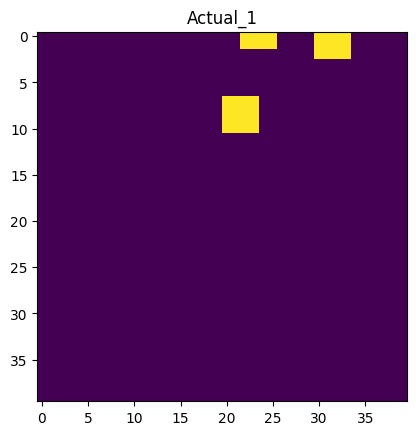

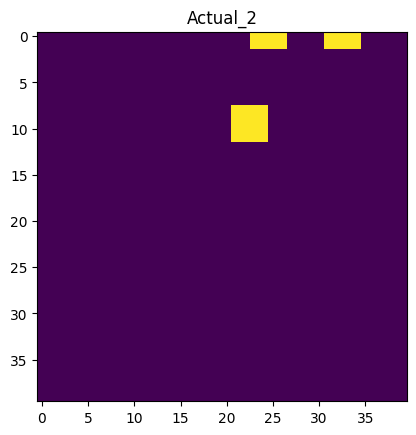

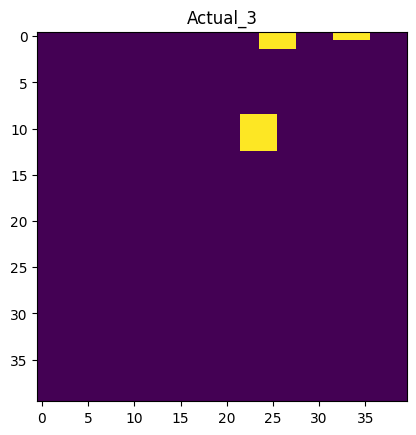

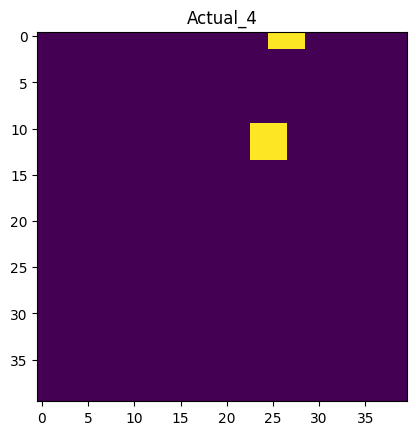

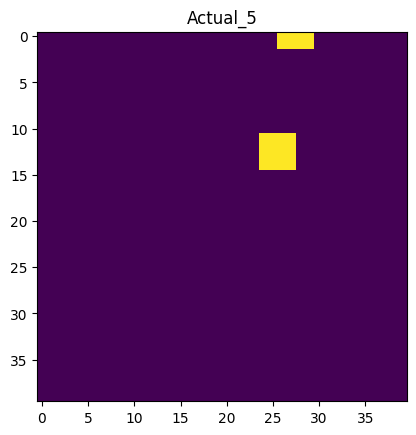

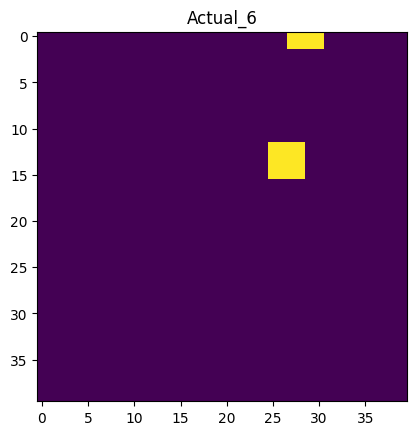

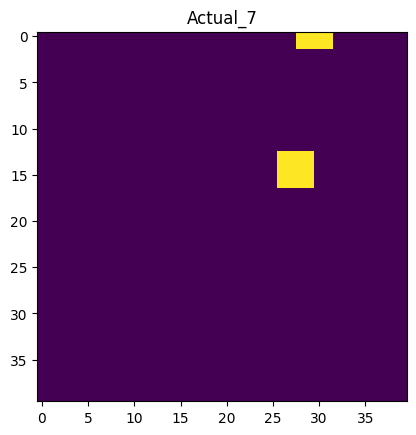

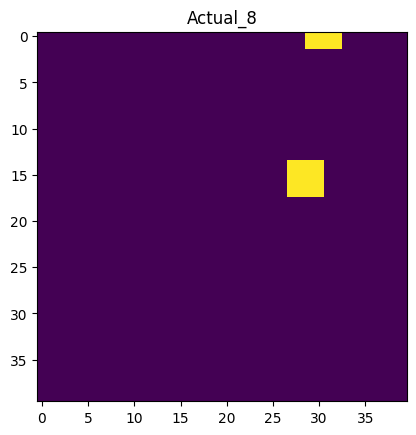

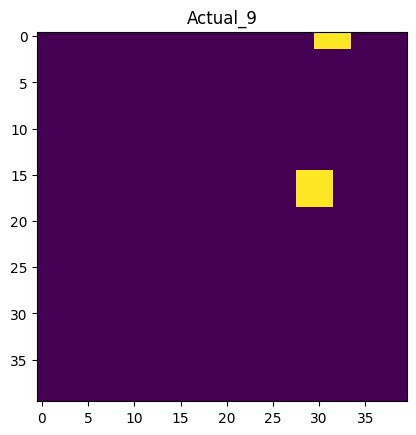

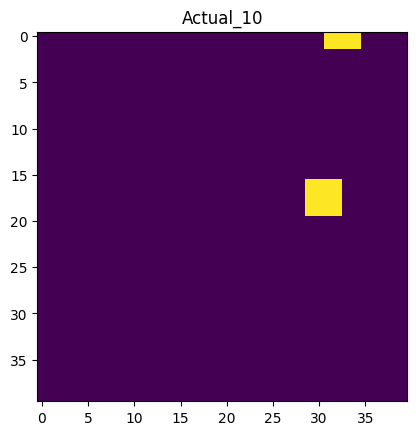

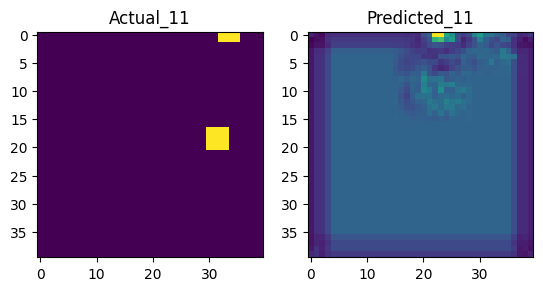

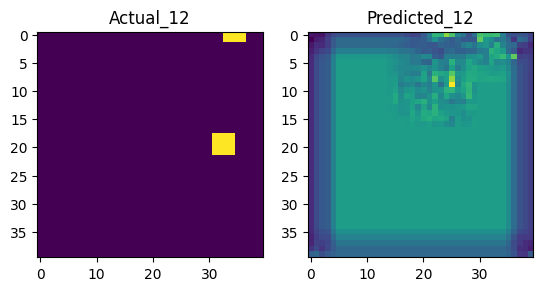

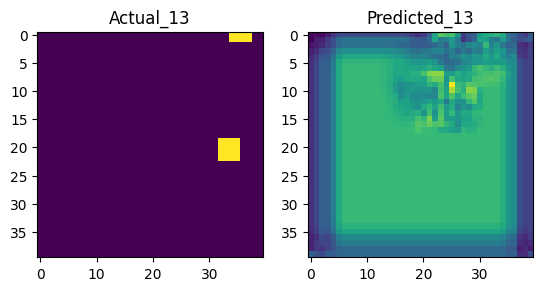

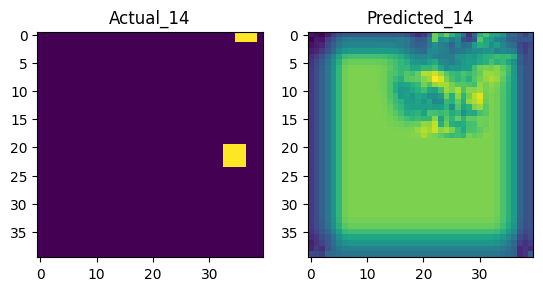

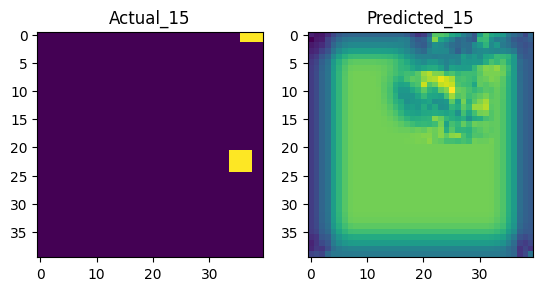

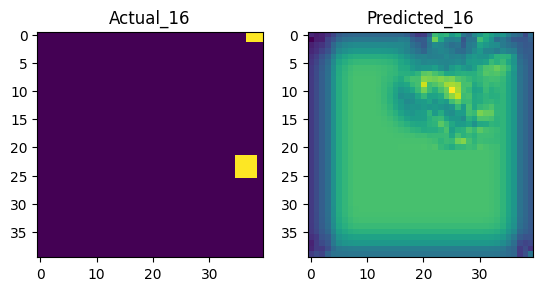

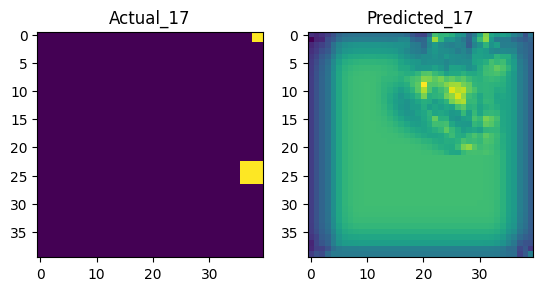

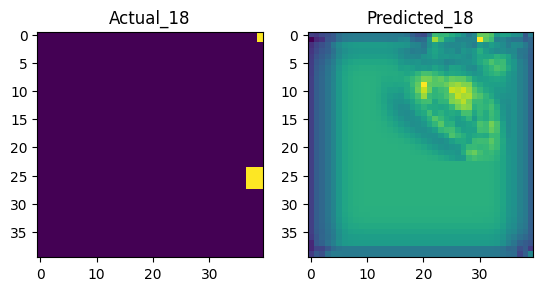

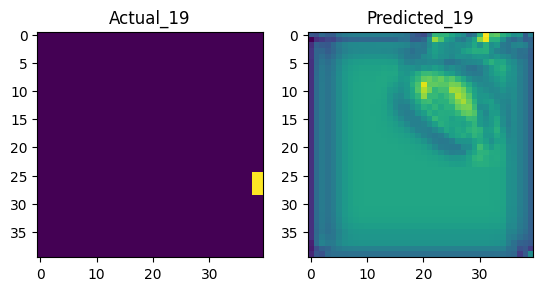

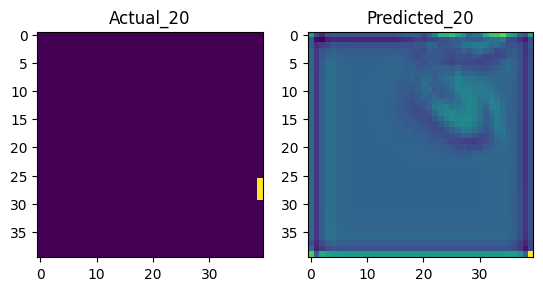

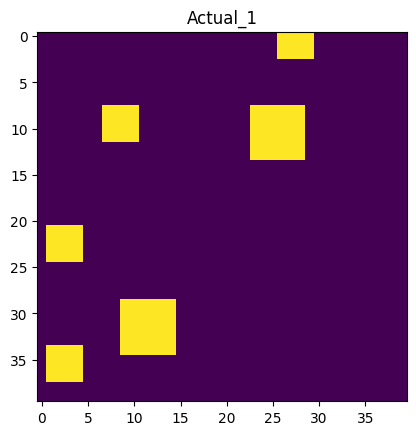

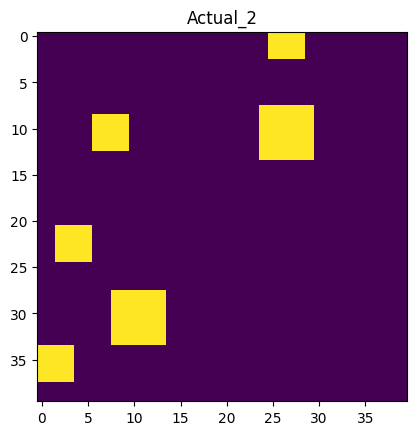

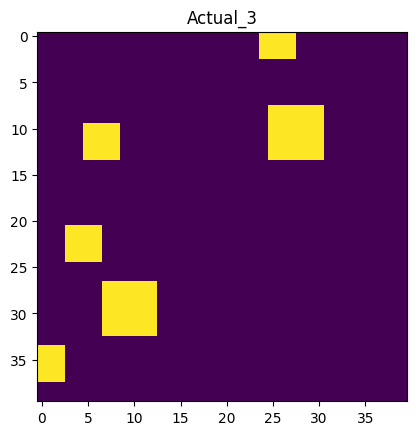

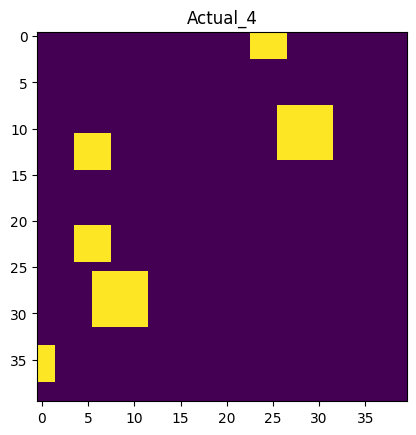

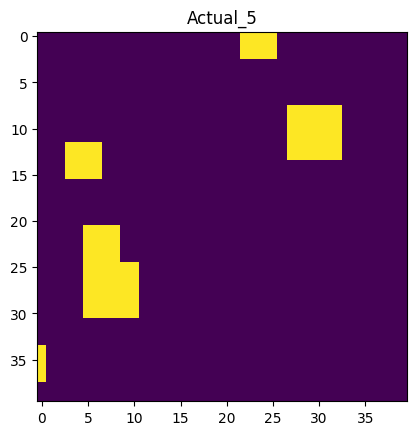

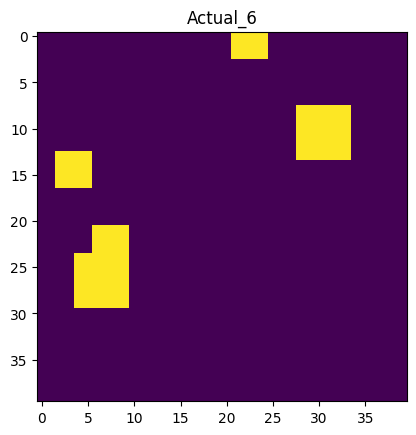

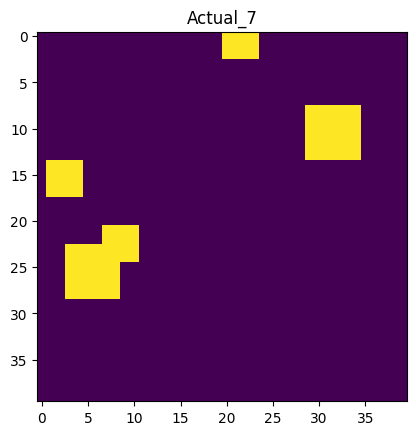

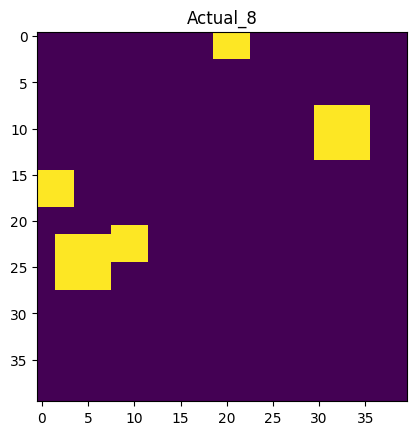

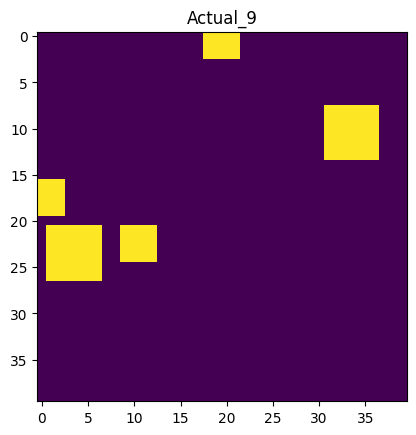

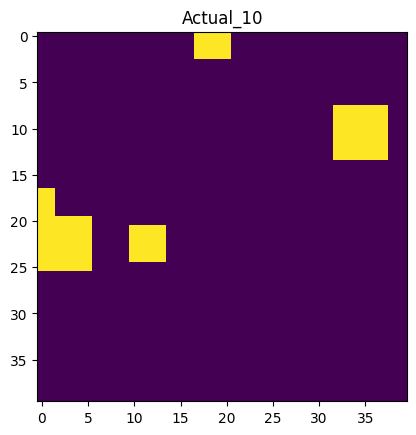

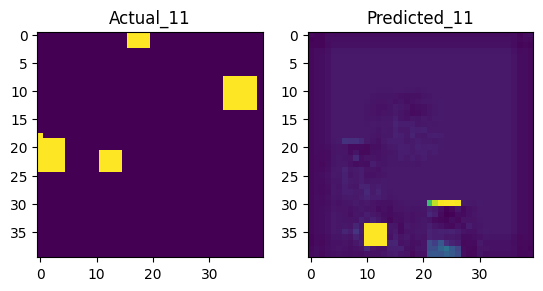

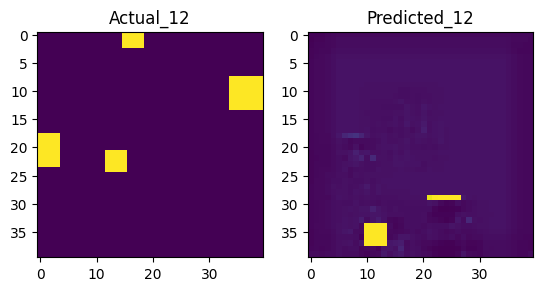

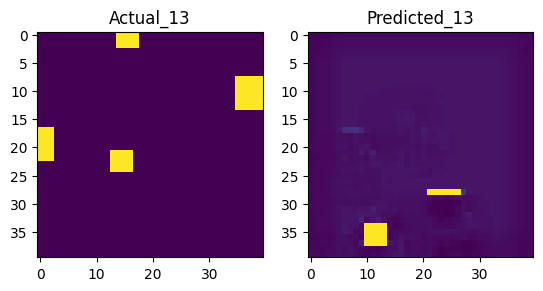

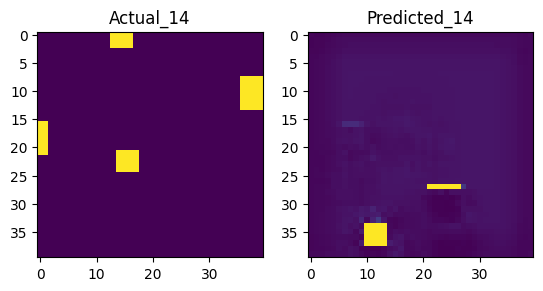

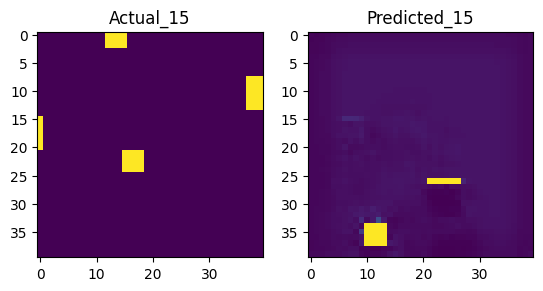

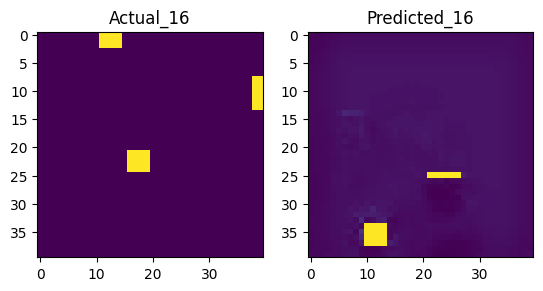

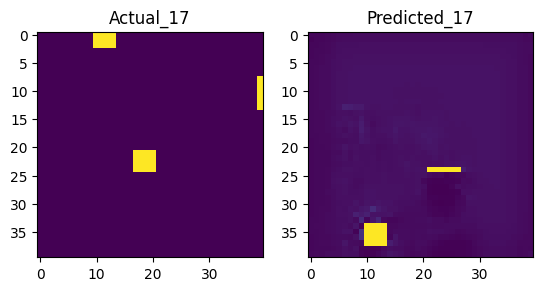

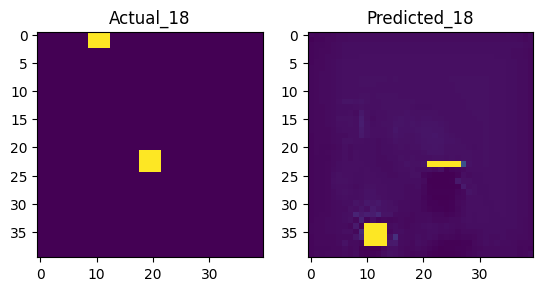

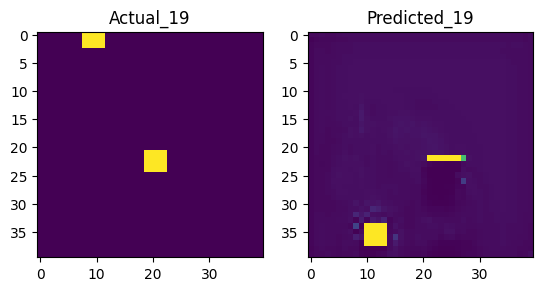

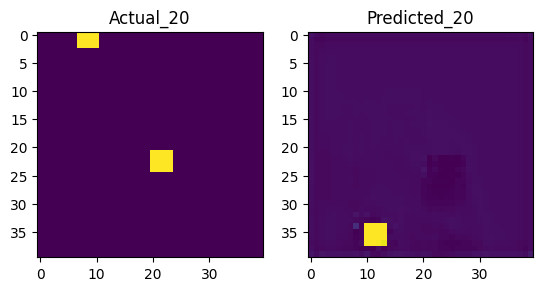

In [ ]:
plot_result(X[2000].numpy(), Y[2000].numpy(), y_pred1[0])
plot_result(X[2001].numpy(), Y[2001].numpy(), y_pred2[1])

In [ ]:
create_gif(X[2000].numpy(), Y[2000].numpy(), y_pred1[0], gif_name="prediction1.gif")
create_gif(X[2001].numpy(), Y[2001].numpy(), y_pred2[1], gif_name="prediction2.gif")

<ipython-input-11-5ae552927827>:29: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')


GIF saved as prediction1.gif
GIF saved as prediction2.gif


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)             │ (None, 10, 40, 40, 64)      │         150,016 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 10, 40, 40, 64)      │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)           │ (None, 10, 40, 40, 64)      │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 10, 40, 40, 64)      │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_2 (ConvLSTM2D)           │ (None, 10, 40, 40, 32)      │         110,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 10, 40, 40, 32)      │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d (Conv3D)                      │ (None, 10, 40, 40, 1)       │             865 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,671,589 (6.38 MB)

 Trainable params: 557,089 (2.13 MB)

 Non-trainable params: 320 (1.25 KB)

 Optimizer params: 1,114,180 (4.25 MB)

In [ ]:
def build_model_2(input_shape=(10, 40, 40, 1)):

    inputs = layers.Input(shape=input_shape)

    x = layers.ConvLSTM2D(filters=64, kernel_size=(3, 3), padding='same',
                          return_sequences=True, activation='relu')(inputs)
    x = layers.BatchNormalization()(x)

    x = layers.ConvLSTM2D(filters=64, kernel_size=(3, 3), padding='same',
                          return_sequences=True, activation='relu')(x)
    x = layers.BatchNormalization()(x)

    attention = layers.Conv3D(filters=1, kernel_size=(1, 1, 1), activation='sigmoid')(x)
    x = layers.Multiply()([x, attention])

    residual = layers.ConvLSTM2D(filters=64, kernel_size=(3, 3), padding='same',
                                 return_sequences=True, activation='relu')(x)
    residual = layers.BatchNormalization()(residual)
    x = layers.Add()([x, residual])

    outputs = layers.Conv3D(filters=1, kernel_size=(3, 3, 3), padding='same', activation='sigmoid')(x)

    model = models.Model(inputs, outputs)
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
                  loss='mean_squared_error',
                  metrics=['accuracy'])
    return model

In [ ]:
model2 = build_model_2(input_shape=(10, 40, 40, 1))

model2.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 10, 40, 40, 1)  │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_lstm2d_4             │ (None, 10, 40, 40, 64) │        150,016 │ input_layer_2[0][0]    │
│ (ConvLSTM2D)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 10, 40, 40, 64) │            256 │ conv_lstm2d_4[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_lstm2d_5             │ (None, 10, 40, 40, 64) │        295,168 │ batch_normalization_5… │
│ (ConvLSTM2D)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_6     │ (None, 10, 40, 40, 64) │            256 │ conv_lstm2d_5[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_4 (Conv3D)         │ (None, 10, 40, 40, 1)  │             65 │ batch_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply (Multiply)       │ (None, 10, 40, 40, 64) │              0 │ batch_normalization_6… │
│                           │                        │                │ conv3d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_lstm2d_6             │ (None, 10, 40, 40, 64) │        295,168 │ multiply[0][0]         │
│ (ConvLSTM2D)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_7     │ (None, 10, 40, 40, 64) │            256 │ conv_lstm2d_6[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 10, 40, 40, 64) │              0 │ multiply[0][0],        │
│                           │                        │                │ batch_normalization_7… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_5 (Conv3D)         │ (None, 10, 40, 40, 1)  │          1,729 │ add[0][0]              │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 742,914 (2.83 MB)

 Trainable params: 742,530 (2.83 MB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
model = build_model_2(input_shape=(10, 40, 40, 1))

model.fit(X[:2000], Y[:2000], epochs=20, batch_size=8, validation_split=0.1)


Epoch 1/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 53s 194ms/step - accuracy: 0.8568 - loss: 0.1168 - val_accuracy: 0.9460 - val_loss: 0.1042
Epoch 2/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 76s 188ms/step - accuracy: 0.9628 - loss: 0.0356 - val_accuracy: 0.9560 - val_loss: 0.0433
Epoch 3/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 83s 193ms/step - accuracy: 0.9646 - loss: 0.0340 - val_accuracy: 0.9575 - val_loss: 0.0409
Epoch 4/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 81s 187ms/step - accuracy: 0.9650 - loss: 0.0337 - val_accuracy: 0.9629 - val_loss: 0.0356
Epoch 5/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 42s 186ms/step - accuracy: 0.9652 - loss: 0.0336 - val_accuracy: 0.9636 - val_loss: 0.0352
Epoch 6/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 84s 193ms/step - accuracy: 0.9648 - loss: 0.0340 - val_accuracy: 0.9636 - val_loss: 0.0351
Epoch 7/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 42s 185ms/step - accuracy: 0.9658 - loss: 0.0330 - val_accuracy: 0.9637 - val_loss: 0.0350
Epoch 8/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 84s 194ms/step - accuracy: 0.9652 - loss: 0

In [ ]:
model.save('model_2.h5')

In [ ]:
y2_pred1 = model.predict(X[2000:2010])
y2_pred2 = model.predict(X[2010:2020])

save_frames2(y2_pred1, sample_index=0, output_dir="output_frames")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
plot_result(X[2000].numpy(), Y[2000].numpy(), y2_pred1[0])
plot_result(X[2001].numpy(), Y[2001].numpy(), y2_pred2[1])

In [ ]:
create_gif(X[2000].numpy(), Y[2000].numpy(), y2_pred1[0], gif_name="prediction3.gif")

create_gif(X[2001].numpy(), Y[2001].numpy(), y2_pred2[1], gif_name="prediction4.gif")

<ipython-input-23-7c5333397ad9>:45: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')


GIF saved as prediction3.gif
GIF saved as prediction4.gif


In [ ]:
def build_model_3(input_shape=(10, 40, 40, 1)):
    inputs = layers.Input(shape=input_shape)

    cnn_features = layers.TimeDistributed(layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'))(inputs)
    cnn_features = layers.TimeDistributed(layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'))(cnn_features)
    cnn_features = layers.TimeDistributed(layers.MaxPooling2D(pool_size=(2, 2)))(cnn_features)
    cnn_features = layers.TimeDistributed(layers.BatchNormalization())(cnn_features)

    rnn_output = layers.ConvLSTM2D(filters=64, kernel_size=(3, 3), padding='same', return_sequences=True, activation='relu')(cnn_features)
    rnn_output = layers.BatchNormalization()(rnn_output)

    x = layers.Conv3D(filters=32, kernel_size=(3, 3, 3), padding='same', activation='relu')(rnn_output)
    x = layers.Conv3D(filters=16, kernel_size=(3, 3, 3), padding='same', activation='relu')(x)

    x = layers.UpSampling3D(size=(1, 2, 2))(x)

    outputs = layers.Conv3D(filters=1, kernel_size=(3, 3, 3), padding='same', activation='sigmoid')(x)

    model = models.Model(inputs, outputs)
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
              loss='mean_squared_error',
              metrics=['accuracy'])
    return model

In [ ]:
model3 = build_model_3(input_shape=(10, 40, 40, 1))

model3.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 10, 40, 40, 1)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 10, 40, 40, 32)      │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 10, 40, 40, 32)      │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 10, 20, 20, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ (None, 10, 20, 20, 32)      │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d (ConvLSTM2D)             │ (None, 10, 20, 20, 64)      │         221,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 10, 20, 20, 64)      │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d (Conv3D)                      │ (None, 10, 20, 20, 32)      │          55,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_1 (Conv3D)                    │ (None, 10, 20, 20, 16)      │          13,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling3d (UpSampling3D)         │ (None, 10, 40, 40, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_2 (Conv3D)                    │ (None, 10, 40, 40, 1)       │             433 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 300,993 (1.15 MB)

 Trainable params: 300,801 (1.15 MB)

 Non-trainable params: 192 (768.00 B)

In [ ]:
model3 = build_model_3(input_shape=(10, 40, 40, 1))

model3.fit(X[:2000], Y[:2000], epochs=20, batch_size=8, validation_split=0.1)


Epoch 1/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 25s 50ms/step - accuracy: 0.8523 - loss: 0.1031 - val_accuracy: 0.9551 - val_loss: 0.0559
Epoch 2/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 29s 40ms/step - accuracy: 0.9615 - loss: 0.0372 - val_accuracy: 0.9643 - val_loss: 0.0347
Epoch 3/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.9640 - loss: 0.0338 - val_accuracy: 0.9653 - val_loss: 0.0315
Epoch 4/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.9657 - loss: 0.0310 - val_accuracy: 0.9680 - val_loss: 0.0280
Epoch 5/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.9686 - loss: 0.0276 - val_accuracy: 0.9751 - val_loss: 0.0218
Epoch 6/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.9747 - loss: 0.0219 - val_accuracy: 0.9793 - val_loss: 0.0176
Epoch 7/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.9794 - loss: 0.0175 - val_accuracy: 0.9838 - val_loss: 0.0136
Epoch 8/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.9832 - loss: 0.0139 - val_a

In [ ]:
model3.save('model_3.h5')

In [ ]:
model3 =  build_model_3(input_shape=(10, 40, 40, 1))
model3.load_weights('/content/model_3.h5')

In [ ]:
y3_pred1 = model3.predict(X[2000:2010])

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [ ]:
create_gif(X[2000].numpy(), Y[2000].numpy(), y3_pred1[0], gif_name="prediction3.gif")

<ipython-input-6-5ae552927827>:29: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')


GIF saved as prediction3.gif
